# Prediction of relevant protein kinase-cancer relations
We aim to learn pairs (x,y), where x is a protein kinase and y is a cancer that 
can be effectively treated by inhibiting x. We use word2vec to embed words found
in abstracts from the PubMed corpus; we use [marea](https://github.com/TheJacksonLaboratory/marea) to preprocess PubMed abstracts by replacing words and phrases with concept IDs, followed by analysis with [embiggen](https://pypi.org/project/embiggen/) for word embedding. This notebook imports the embedded vectors and corresponding labels (words) from embiggen. We then extract vectors that correspond to
both protein kinases and cancers. We use a positive set of (x,y) relations that
we have derived from an analysis of Clinical Trials data with [yatcp](https://github.com/monarch-initiative/yactp), and rank other possible protein-kinase cancer relations.

## How to set up this notebook
This notebook depends on the files ``embedding_SG_dim100_upto{year}.npy``, ``words_SG_upto{year}.txt`` (from embiggen), 
``positive_training_upto_{year}.tsv``, ``negative_training_upto_{year}.tsv``, ``positive_validation_x_years_after_{year}.tsv``, ``negative_prediction_x_years_after_{year}.tsv`` from the [KCET](https://github.com/TheJacksonLaboratory/KCET) package. For now, the corresponding files are available in
Google drive. Download that folder to someplace on your drive, and then cd to the KCET/notebooks folder,
and softlist the downloaded folder
```
ln -s /path/to/downloaded/folder/ data
```
This notebook assumes it will find the files there.

In [1]:
import os
import sys
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sys.path.insert(0, os.path.abspath('../..'))
from kcet import KinasePredictor

In [2]:
target_year = 2010
num_years_later = 9

## Input files
``embedding_SG_dim100_upto{year}.npy`` is the result of word2vec embedding of pubmed. ``words_SG_upto{}.txt`` are the corresponding words. A directory of files was downloaded and softlinked to data using ``ln -s <path> data``.

In [3]:
data_directory = '../data/embeddings_final'
if not os.path.isdir(data_directory):
    raise FileNotFoundError("Could not find data directory")
embedding_file = os.path.join(data_directory, "embedding_SG_dim100_upto{}.npy".format(target_year))
words_file = os.path.join(data_directory, "words_SG_upto{}.txt".format(target_year))
predictor = KinasePredictor(embeddings=embedding_file, words=words_file)


[INFO] We ingested 195088 labeled word vectors from ../data/embeddings_final/embedding_SG_dim100_upto2010.npy and ../data/embeddings_final/words_SG_upto2010.txt
[INFO] We ingested 522 symbol/NCBI gene id mappings from /Users/ravanv/PycharmProjects/KCET/input/prot_kinase.tsv
[INFO] We ingested 698 meshId/disease mappings from /Users/ravanv/PycharmProjects/KCET/input/neoplasms_labels.tsv



# PubMed Word Embeddings
The following code displays the numbers of word embeddings used as input.

In [4]:
embeddings = predictor.get_embeddings()
embeddings.head(n=10)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
cell,-2.641621,3.124869,-4.353377,-2.018315,1.823348,-4.975201,-4.787686,2.649930,-2.948251,-0.916163,...,-1.869853,-3.522519,2.618166,-4.450459,-3.961528,-2.892118,-5.928490,0.367299,-4.532290,2.421597
patient,-3.817505,2.731132,-3.133406,-3.360924,3.251447,-3.779796,-4.411118,2.816041,-5.475833,-2.382731,...,-1.941187,-5.431289,2.350188,-5.862311,-3.625207,-4.146669,-4.293906,0.900865,-4.954704,3.698488
meshd009369,-2.000293,2.692290,-3.906482,-2.403826,2.087734,-4.683461,-4.715221,3.363425,-3.719787,-1.557153,...,-1.572250,-5.367291,2.859295,-5.173111,-5.736109,-3.077639,-3.752953,0.597677,-3.388928,4.321077
study,-3.286283,2.197396,-3.055143,-3.488384,1.583849,-3.476388,-4.572982,2.568147,-4.655032,-2.002333,...,-1.750167,-4.790527,2.999226,-5.209653,-4.173866,-6.466439,-4.163732,0.406401,-3.173547,2.894467
1,-1.973735,2.599354,-4.169664,-2.950947,1.642805,-4.464195,-4.122997,3.285105,-3.085233,-2.332377,...,-1.851673,-4.228116,2.728837,-6.189056,-3.837825,-5.297565,-4.471994,0.961740,-3.943491,3.863080
0,-2.586123,2.689704,-4.212170,-3.771425,1.231912,-4.831149,-4.203139,2.516318,-4.278717,-0.870984,...,-1.646774,-3.917393,3.147377,-6.403146,-3.208885,-4.337939,-5.274619,1.493022,-4.262381,3.811445
case,-2.901989,3.094942,-2.662760,-2.999618,3.339018,-4.174236,-3.733308,3.043080,-5.015265,-2.009101,...,-1.629706,-5.274364,2.490766,-6.020258,-4.223149,-5.065413,-4.717482,1.171679,-4.160813,3.578443
2,-1.995389,2.613357,-4.465601,-3.374403,1.476374,-3.963554,-4.275064,3.415569,-3.165894,-2.673264,...,-1.870650,-4.507325,2.781323,-6.268209,-3.587891,-5.258845,-4.164574,0.931996,-4.031983,3.908941
use,-2.350996,2.471157,-3.943660,-4.285838,1.903959,-3.824636,-5.363203,3.795658,-3.144410,-2.605247,...,-1.496192,-3.672382,3.161894,-3.771332,-5.287291,-5.904677,-6.007619,0.785128,-5.524373,3.306188
treatment,-4.137800,2.313303,-4.491300,-4.538378,2.906991,-3.536086,-5.214668,3.688766,-3.349134,-2.446090,...,-1.661259,-3.453831,2.958672,-6.402697,-2.986871,-6.025044,-3.379093,0.627732,-5.395659,5.521724


In [5]:
print("Total number of embeddings: ", len(embeddings))

Total number of embeddings:  195088


# Positive examples
Note that we need to rename the gene.id to gene_id upstream TODO

In [6]:
positive_examples = "positive_training_upto_{}.tsv".format(target_year)
positive_df = pd.read_csv(positive_examples,  sep= "\t")[["mesh_id", "gene_id"]]
positive_df.head()

,mesh_id,gene_id
0,meshd015179,ncbigene1956
1,meshd009362,ncbigene1956
2,meshd016609,ncbigene1956
3,meshd008113,ncbigene1956
4,meshd002289,ncbigene1956


In [7]:
print("%d positive examples" % len(positive_df))
print("%d embedded words in total" % len(predictor.get_embeddings()))

161 positive examples
195088 embedded words in total


# Difference vectors
We form difference vectors by substracting the word vectors for the protein kinases (in the column ``gene.id``)
from the corresponding vectors for the cancer (in the column ``mesh_id``). The following function in the
KCET package takes the dataframe shown above, finds the corrresponding vectors, substracts them, and
returns a new Pandas dataframe.

In [8]:
diff_vectors_pos_train = predictor.get_disease_kinase_difference_vectors(examples=positive_df)

[INFO] Extracted 132 kinase-cancer difference vectors
[INFO]	Initial data: 161 examples
[INFO]	Could not identify 1 gene ids
[INFO]	Could not identify 0 MeSH ids


In [9]:
diff_vectors_pos_train.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ncbigene1956-meshd015179,-1.758768,0.821506,-0.218957,-0.418908,1.173821,2.282200,-0.896008,0.869499,-0.596625,-1.125477,...,0.244606,-0.978184,-0.364866,-0.861954,2.721985,0.355013,-1.774969,0.447741,0.221942,0.967503
ncbigene1956-meshd009362,-0.488660,-0.127344,1.152679,-1.458963,0.629901,1.370382,-0.432642,-0.060593,-0.768857,-0.831967,...,-0.106943,-2.545844,1.020391,2.764358,0.198052,-1.228320,-2.482996,0.121853,-0.002106,-0.983001
ncbigene1956-meshd016609,1.205292,0.113798,-1.177771,-1.224409,-0.320766,0.655336,-1.157197,1.443528,-1.263317,-1.750137,...,0.342476,-3.346388,-0.123938,-0.298214,0.739539,-0.900963,-2.440659,1.079363,0.378580,-1.017632
ncbigene1956-meshd008113,0.243748,0.850496,-0.247731,-1.412440,-1.462184,3.085130,-1.012596,2.120200,-1.968772,-2.174910,...,0.080879,-2.727978,0.043658,-0.467317,0.111648,0.602614,-2.497726,0.504189,-1.959718,0.611904
ncbigene1956-meshd002289,-0.197365,0.567358,-0.211547,0.391760,0.885465,2.867372,0.110631,1.182542,1.366991,-1.176261,...,0.283839,-0.278417,0.089316,0.738022,1.080370,-0.954275,-1.885794,0.135279,-1.811702,-0.210935


In [10]:
print("%d total difference vectors were extracted." % len(diff_vectors_pos_train))

132 total difference vectors were extracted.


# Negative examples
Here, we process negative examples in the same way. TODO LINK TO EXPLANATION OF HOW WE MAKE POS AND NEG

In [11]:
negative_examples =  "negative_training_upto_{}.tsv".format(target_year)
negative_df = pd.read_csv(negative_examples,  sep= "\t")[["mesh_id", "gene_id"]]
negative_df.head()

,mesh_id,gene_id
0,meshd009364,ncbigene10290
1,meshd018205,ncbigene27347
2,meshd018222,ncbigene5871
3,meshd015831,ncbigene55781
4,meshd010048,ncbigene5563


In [12]:
print("%d negative examples" % len(negative_df))

1350 negative examples


In [13]:
diff_vectors_neg_train = predictor.get_disease_kinase_difference_vectors(examples=negative_df)

[INFO] Extracted 1160 kinase-cancer difference vectors
[INFO]	Initial data: 1350 examples
[INFO]	Could not identify 39 gene ids
[INFO]	Could not identify 45 MeSH ids


In [14]:
diff_vectors_neg_train.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ncbigene10290-meshd009364,1.046382,-1.317145,1.672593,1.496852,-0.068695,2.471346,1.678724,-1.813887,1.514891,0.343644,...,0.763156,2.394332,-1.086147,3.282635,1.617437,1.507984,2.249555,-0.532501,2.035141,-2.285908
ncbigene5871-meshd018222,0.103396,0.516642,0.424417,-0.026336,-0.032216,0.294833,0.581536,0.069479,0.514657,-0.211011,...,-0.495553,0.023037,0.676651,0.313318,0.206324,0.121972,0.351874,0.394714,0.176627,-0.453661
ncbigene55781-meshd015831,2.135211,-2.317097,1.981997,0.465225,-1.032022,2.078514,1.752292,-1.915700,1.162689,0.391494,...,0.410560,1.419800,-0.940398,3.519653,1.738690,2.710532,2.386828,-0.327604,3.509367,-3.179401
ncbigene5563-meshd010048,2.285714,-1.251601,-0.720041,-2.505419,-0.074795,-0.416318,-0.580781,-0.337641,-0.231069,-0.666247,...,-0.548478,0.936572,0.752196,0.805160,1.878329,0.884641,-0.992880,-1.186680,1.235328,0.258826
ncbigene6714-meshd002822,2.451729,0.130606,-0.940668,-3.173994,0.285665,0.159981,-0.979413,0.289093,0.563777,-0.737425,...,-0.234071,-1.299855,0.281501,-0.460733,1.612049,-1.007069,-0.722369,-0.804761,0.321157,0.038107


# PCA visualization
To do PCA, we concatenate the positive and negative examples and label them so that we can visualize them using PCA.

In [15]:
X_train = diff_vectors_pos_train.append(diff_vectors_neg_train)
print("[INFO] We combined positive (n=%d) and negative (n=%d) to the combined dataframe (%d)" % 
      (len(diff_vectors_pos_train), len(diff_vectors_neg_train), len(X_train)))

[INFO] We combined positive (n=132) and negative (n=1160) to the combined dataframe (1292)


In [16]:
X_train.values

array([[-1.7587682e+00,  8.2150578e-01, -2.1895671e-01, ...,
         4.4774115e-01,  2.2194195e-01,  9.6750259e-01],
       [-4.8866010e-01, -1.2734413e-01,  1.1526792e+00, ...,
         1.2185264e-01, -2.1064281e-03, -9.8300052e-01],
       [ 1.2052921e+00,  1.1379838e-01, -1.1777706e+00, ...,
         1.0793628e+00,  3.7857962e-01, -1.0176322e+00],
       ...,
       [-8.4422755e-01,  8.4754324e-01, -2.2020345e+00, ...,
        -1.0377157e-01, -1.3184416e+00,  1.3677486e+00],
       [ 2.1442313e+00, -1.6762235e+00,  1.0598671e+00, ...,
        -7.7177370e-01,  1.7675257e+00, -7.9373181e-01],
       [ 1.7741075e+00, -1.6403691e+00,  1.5548692e+00, ...,
        -8.0076170e-01,  2.1594882e-01,  4.8252106e-01]], dtype=float32)

In [17]:
# vector with colors for the data points -- red for positive, blue for negative
cvec = [ "red" if i < len(diff_vectors_pos_train) else "blue" for i in range(len(X_train))]

In [18]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X_train.values)
df = pd.DataFrame()
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.6113605  0.05238666 0.03230818]


Text(0, 0.5, 'PC 2 (5.24%)')

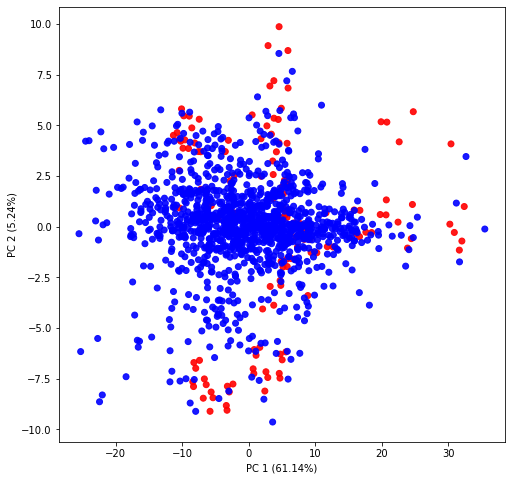

In [19]:
plt.figure(figsize=(8,8))

plt.scatter(pca_result[:,0], pca_result[:,1],c=cvec, alpha=0.9)
plt.xlabel('PC 1 (%.2f%%)' % (pca.explained_variance_ratio_[0]*100))
plt.ylabel('PC 2 (%.2f%%)' % (pca.explained_variance_ratio_[1]*100)) 

# T-Distributed Stochastic Neighbouring Entities (t-SNE) Plot

In [20]:
import time
from sklearn.manifold import TSNE
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(pca_result)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1292 samples in 0.001s...
[t-SNE] Computed neighbors for 1292 samples in 0.072s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1292
[t-SNE] Computed conditional probabilities for sample 1292 / 1292
[t-SNE] Mean sigma: 1.213504
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.161972
[t-SNE] KL divergence after 300 iterations: 0.766938
t-SNE done! Time elapsed: 5.389355897903442 seconds


Text(0, 0.5, 'tsne-2d-two')

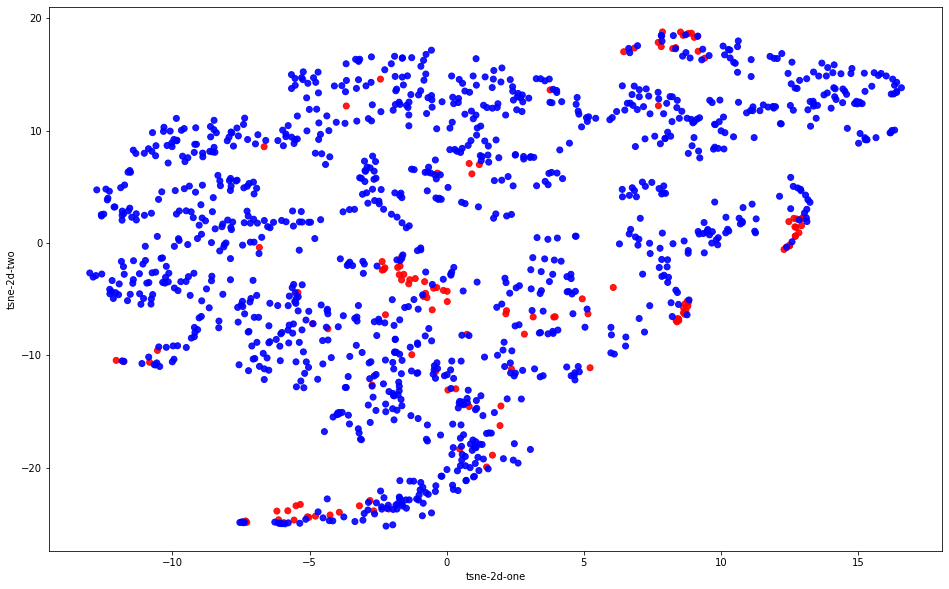

In [21]:
plt.figure(figsize=(16,10))
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=cvec,  alpha=0.9)
plt.xlabel('tsne-2d-one')
plt.ylabel('tsne-2d-two') 

# Random forest
First, let's arrange the training data. X_train we have from above. We additionally need to create a data structure for the labels with 1=positive, 0=negative example

In [22]:
print("Training data dimensions:", X_train.shape)

Training data dimensions: (1292, 100)


In [23]:
label_1 = np.ones(diff_vectors_pos_train.shape[0])
label_0 = np.zeros(diff_vectors_neg_train.shape[0])
Y_train = np.concatenate((label_1,label_0))
n_pos_examples = sum([x for x in Y_train])
n_neg_examples = sum([(1-x) for x in Y_train])
print("Number of positive examples: %d, number of negative examples: %d, Y_train.shape: %s" % (n_pos_examples, n_neg_examples, Y_train.shape))

Number of positive examples: 132, number of negative examples: 1160, Y_train.shape: (1292,)


## Positive validation data
Note that for this pilot experiment, we are not checking ROC, but we are just predicting values for all combinations of protein kinases and cancers

In [24]:
positive_validation_data =  "positive_validation_{}_years_after_{}.tsv".format(num_years_later, target_year)
positive_validation_df = pd.read_csv(positive_validation_data, sep='\t')[["mesh_id", "gene_id"]]


In [25]:
positive_validation_df.head()

,mesh_id,gene_id
0,meshd058922,ncbigene2066
1,meshd054219,ncbigene5894
2,meshd012509,ncbigene4914
3,meshd001752,ncbigene3932
4,meshd002277,ncbigene55589


In [26]:
diff_vectors_pos_validation = predictor.get_disease_kinase_difference_vectors(positive_validation_df)

[INFO] Extracted 4420 kinase-cancer difference vectors
[INFO]	Initial data: 4794 examples
[INFO]	Could not identify 2 gene ids
[INFO]	Could not identify 21 MeSH ids


In [27]:
diff_vectors_pos_validation.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ncbigene2066-meshd058922,0.289029,0.101123,-0.470073,0.510933,0.598628,1.845981,0.169063,0.257286,-0.056741,0.142358,...,-0.014623,-0.745960,0.294278,0.341473,-0.524124,-0.172545,-0.871770,-0.402218,-0.185114,-0.445835
ncbigene5894-meshd054219,-1.027482,1.815699,-2.569277,-2.416114,1.185430,-1.338889,-1.515580,2.549001,-1.461044,-0.807323,...,-1.337116,-2.068337,1.336264,-3.367961,-1.811296,-2.589670,-1.927113,-0.336214,-2.282250,1.071156
ncbigene4914-meshd012509,0.465808,0.101000,-0.766718,-1.442418,-0.085436,2.542539,0.180107,-0.606859,-2.544259,0.871655,...,0.326717,0.885636,0.629953,0.353642,1.136249,-1.523986,-2.053727,0.520913,-1.863617,-0.126089
ncbigene3932-meshd001752,-0.686596,1.573136,-2.263627,-2.146373,0.766428,-0.567917,-1.613770,3.061517,-2.027709,-0.878040,...,-0.955363,-2.288947,1.147374,-2.264712,-2.331778,-0.799495,-1.802730,0.035366,-2.050626,1.228626
ncbigene1021-meshd020522,1.304604,-0.111277,-1.115587,-0.754560,-0.120610,0.896148,0.109754,1.845786,0.345486,0.657662,...,0.525059,-0.344811,0.517230,-0.288804,-1.030988,-1.035817,0.715262,-0.359817,0.373009,0.814272


## Negative validation data

In [28]:
negative_validation_data = "negative_validation_{}_years_after_{}.tsv".format(num_years_later, target_year)
negative_validation_df = pd.read_csv(negative_validation_data, sep='\t')[["mesh_id", "gene_id"]]


In [29]:
negative_validation_df.head()

,mesh_id,gene_id
0,meshd007340,ncbigene65268
1,meshd010310,ncbigene3791
2,meshd009078,ncbigene2870
3,meshd000071960,ncbigene2044
4,meshd000086002,ncbigene22853


In [30]:
diff_vectors_neg_validation = predictor.get_disease_kinase_difference_vectors(negative_validation_df)

[INFO] Extracted 1148 kinase-cancer difference vectors
[INFO]	Initial data: 1350 examples
[INFO]	Could not identify 38 gene ids
[INFO]	Could not identify 48 MeSH ids


In [31]:
diff_vectors_neg_validation.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ncbigene65268-meshd007340,1.541112,-1.434097,1.862877,0.785598,-1.541409,2.231915,0.623406,0.364329,1.689404,-0.464303,...,0.519735,1.507569,-0.909664,2.705227,2.474116,0.695626,0.748155,-1.235382,2.199449,1.863636
ncbigene3791-meshd010310,1.967987,1.310518,-1.537180,-1.774661,0.813112,-1.205657,-1.922824,1.202925,-1.789170,-0.872988,...,-1.088366,-0.441357,1.044585,-1.996256,-2.094535,-2.403143,-4.371930,0.001352,-0.063767,1.339029
ncbigene2044-meshd000071960,1.735029,-1.205826,0.539631,1.178264,0.434515,1.467629,0.104390,-1.204339,1.219496,0.517745,...,0.635207,1.554842,-1.643396,1.674617,1.426458,0.889209,0.152508,-1.100332,2.024924,-1.501482
ncbigene9874-meshd009347,3.109669,-0.823826,1.883017,-0.045921,-0.755349,1.227775,-0.137584,-0.432677,1.493119,-0.382520,...,0.598456,1.528111,-0.500792,2.540993,2.103801,1.316286,1.045731,-0.715721,1.950667,-0.109239
ncbigene1612-meshd058405,1.269188,-0.860014,0.832255,-1.369929,-0.595926,2.008039,0.422658,-0.407060,-1.577469,-0.437994,...,-0.523806,0.366812,0.643368,0.686584,1.763143,1.168277,0.184485,-0.979107,0.163686,-0.963089


# Save binary versions of the data for use in other notebooks
We 'pickle' the three pandas dataframes produced by the code in this notebook.

In [32]:
positive_valid_diff_pickle_path = "positive-valid-vectors-{}-years-after-{}.pkl".format(num_years_later, target_year)
diff_vectors_pos_validation.to_pickle(positive_valid_diff_pickle_path)

In [33]:
positive_train_diff_pickle_path ="positive-train-vectors-{}.pkl".format(target_year)
diff_vectors_pos_train.to_pickle(positive_train_diff_pickle_path)

In [34]:
negative_train_diff_pickle_path =  "negative-train-vectors-{}.pkl".format(target_year)
diff_vectors_neg_train.to_pickle(negative_train_diff_pickle_path)

In [35]:
negative_valid_diff_pickle_path = "negative-valid-vectors-{}-years-after-{}.pkl".format(num_years_later, target_year)
diff_vectors_neg_validation.to_pickle(negative_valid_diff_pickle_path)